# Build your own Experiment

#### imports

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv

from config import EXPERIMENTAL_DATA_PATH, SAVE_PATH, VIDEOS_PATH


## Pre treatment of raw data from experiment

#### Merge every participant's csv

In [2]:
csv_files = glob.glob(os.path.join(EXPERIMENTAL_DATA_PATH, "*.csv"))
print(f"Found {len(csv_files)} files:\n{csv_files}")

all_data = []
for file in csv_files:
    df = pd.read_csv(file)
    all_data.append(df)

df_combined = pd.concat(all_data, ignore_index=True)

df = df_combined.pivot_table(
    index=['reference', 'condition'],
    columns='participant',
    values='rating',
    aggfunc='first'
).reset_index()

df.columns = ['video', 'condition'] + [f'rating_{col}' for col in df.columns[2:]]

print(f"\nFinal dataframe: {df.shape}")
print(df.head(10))

Found 6 files:
['data/Elliot_01_samviq.csv', 'data/cla_01_samviq.csv', 'data/lou-anne_01_samviq.csv', 'data/Enzo_01_samviq.csv', 'data/christopher_01_samviq.csv', 'data/maria_01_samviq.csv']

Final dataframe: (36, 8)
                 video condition  rating_Elliot  rating_Enzo  \
0  Center_Book_arrival    Fehn_c             86           92   
1  Center_Book_arrival    Fehn_i             88           88   
2  Center_Book_arrival     Holes             35           30   
3  Center_Book_arrival  ICIP_TMM             80           58   
4  Center_Book_arrival      ICME             87           48   
5  Center_Book_arrival  Original            100          100   
6      Center_Lovebird    Fehn_c             90           75   
7      Center_Lovebird    Fehn_i             90           74   
8      Center_Lovebird     Holes             72           25   
9      Center_Lovebird  ICIP_TMM             79           33   

   rating_christopher  rating_cla  rating_lou-anne  rating_maria  
0          

#### Video path

In [3]:
def find_video(originals, ref, condition, data):
    to_cam_position, video_label = ref.split('_', 1)
    if condition == 'Original':
        filtre = (
            (data['Algo'] == condition) &
            (data['from_cam_position'] == originals) &
            (data['Video'].str.contains(video_label, case=False, na=False))
        )
    else :
        filtre = (
            (data['Algo'] == condition) &
            (data['from_cam_position'] == originals) &
            (data['to_cam_position'] == to_cam_position) &
            (data['Video'].str.contains(video_label, case=False, na=False))
        )
    candidates = data.loc[filtre, 'Video_path']
    if candidates.empty:
        print(f"No video found for {originals}, {ref}, {condition}")
    return candidates.iloc[0] if not candidates.empty else None

In [4]:
# Ajouter la colonne ref_video_path et from_video_path TODO








In [5]:
data = pd.read_csv(SAVE_PATH + "df_videos_processed.csv")
df['Video_path'] = pd.Series(dtype=str)

for index, row in df.iterrows():
    originals = 'Left'
    ref = row['video']
    condition = row['condition']
    video_path = find_video(originals, ref, condition, data)
    df.at[index, 'Video_path'] = video_path if video_path else None

df = df[['Video_path'] + [col for col in df.columns if col != 'Video_path']]
print(f"Video paths added")
df.head(10)


Video paths added


,Video_path,video,condition,rating_Elliot,rating_Enzo,rating_christopher,rating_cla,rating_lou-anne,rating_maria
0,Book_arrival_A1_8_to_9.avi,Center_Book_arrival,Fehn_c,86,92,22,59,83,89
1,Book_arrival_A2_8_to_9.avi,Center_Book_arrival,Fehn_i,88,88,35,66,31,76
2,Book_arrival_A7_8_to_9.avi,Center_Book_arrival,Holes,35,30,79,0,13,12
3,Book_arrival_A6_8_to_9.avi,Center_Book_arrival,ICIP_TMM,80,58,48,51,56,55
4,Book_arrival_A5_8_to_9.avi,Center_Book_arrival,ICME,87,48,65,42,19,44
5,Book_arrival_cam_08.avi,Center_Book_arrival,Original,100,100,5,100,96,100
6,Lovebird1_A1_6_to_7.avi,Center_Lovebird,Fehn_c,90,75,26,77,61,73
7,Lovebird1_A2_6_to_7.avi,Center_Lovebird,Fehn_i,90,74,46,91,50,82
8,Lovebird1_A7_6_to_7.avi,Center_Lovebird,Holes,72,25,76,0,22,24
9,Lovebird1_A6_6_to_7.avi,Center_Lovebird,ICIP_TMM,79,33,64,36,24,40


#### MOS, DMOS, CI

In [6]:
# MOS (Mean Opinion Score)
rating_cols = [col for col in df.columns if col.startswith("rating_")]
df["MOS"] = df[rating_cols].mean(axis=1)

# DMOS (Differential Mean Opinion Score)
reference_mos = df[df["condition"] == "Original"].groupby("video")["MOS"].mean()
df = df.join(reference_mos, on="video", rsuffix="_ref")
df["DMOS"] = df["MOS_ref"] - df["MOS"] + 20 ##############################TODO à ajuster

# Confidence Interval 95%
df["STD"] = df[rating_cols].std(axis=1)
nb_participants = len(rating_cols)
df["CI_95"] = 1.96 * df["STD"] / np.sqrt(nb_participants)

df.drop(columns=["MOS_ref", "STD"], inplace=True)
df.head(10)


,Video_path,video,condition,rating_Elliot,rating_Enzo,rating_christopher,rating_cla,rating_lou-anne,rating_maria,MOS,DMOS,CI_95
0,Book_arrival_A1_8_to_9.avi,Center_Book_arrival,Fehn_c,86,92,22,59,83,89,71.833333,31.666667,21.692733
1,Book_arrival_A2_8_to_9.avi,Center_Book_arrival,Fehn_i,88,88,35,66,31,76,64.000000,39.500000,20.337460
2,Book_arrival_A7_8_to_9.avi,Center_Book_arrival,Holes,35,30,79,0,13,12,28.166667,75.333333,22.401332
3,Book_arrival_A6_8_to_9.avi,Center_Book_arrival,ICIP_TMM,80,58,48,51,56,55,58.000000,45.500000,9.095188
4,Book_arrival_A5_8_to_9.avi,Center_Book_arrival,ICME,87,48,65,42,19,44,50.833333,52.666667,18.438011
5,Book_arrival_cam_08.avi,Center_Book_arrival,Original,100,100,5,100,96,100,83.500000,20.000000,30.798621
6,Lovebird1_A1_6_to_7.avi,Center_Lovebird,Fehn_c,90,75,26,77,61,73,67.000000,31.166667,17.697979
7,Lovebird1_A2_6_to_7.avi,Center_Lovebird,Fehn_i,90,74,46,91,50,82,72.166667,26.000000,15.797297
8,Lovebird1_A7_6_to_7.avi,Center_Lovebird,Holes,72,25,76,0,22,24,36.500000,61.666667,24.405739
9,Lovebird1_A6_6_to_7.avi,Center_Lovebird,ICIP_TMM,79,33,64,36,24,40,46.000000,52.166667,16.792065


## Save

In [7]:
output_file = os.path.join(SAVE_PATH, "experimental_results.csv")
df.to_csv(output_file, index=False)
print(f"\nDataframe sauvegardé dans: {output_file}")


Dataframe sauvegardé dans: results/experimental_results.csv


## Statistical analysis of MOS and CI

#### MOS and CI visualization

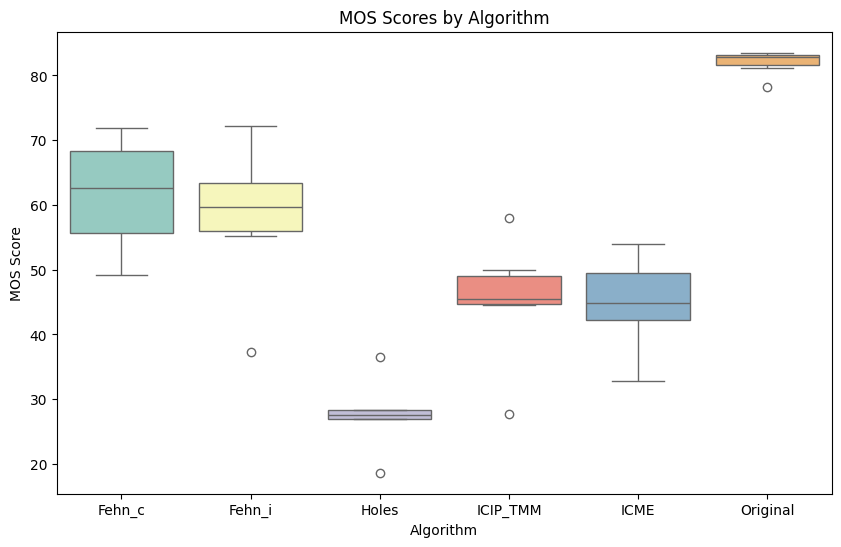

In [8]:
plt.figure(figsize=(10,6))
sns.boxplot(x="condition", y="MOS", data=df, hue="condition", palette="Set3", legend=False)
plt.title("MOS Scores by Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("MOS Score")
plt.show()

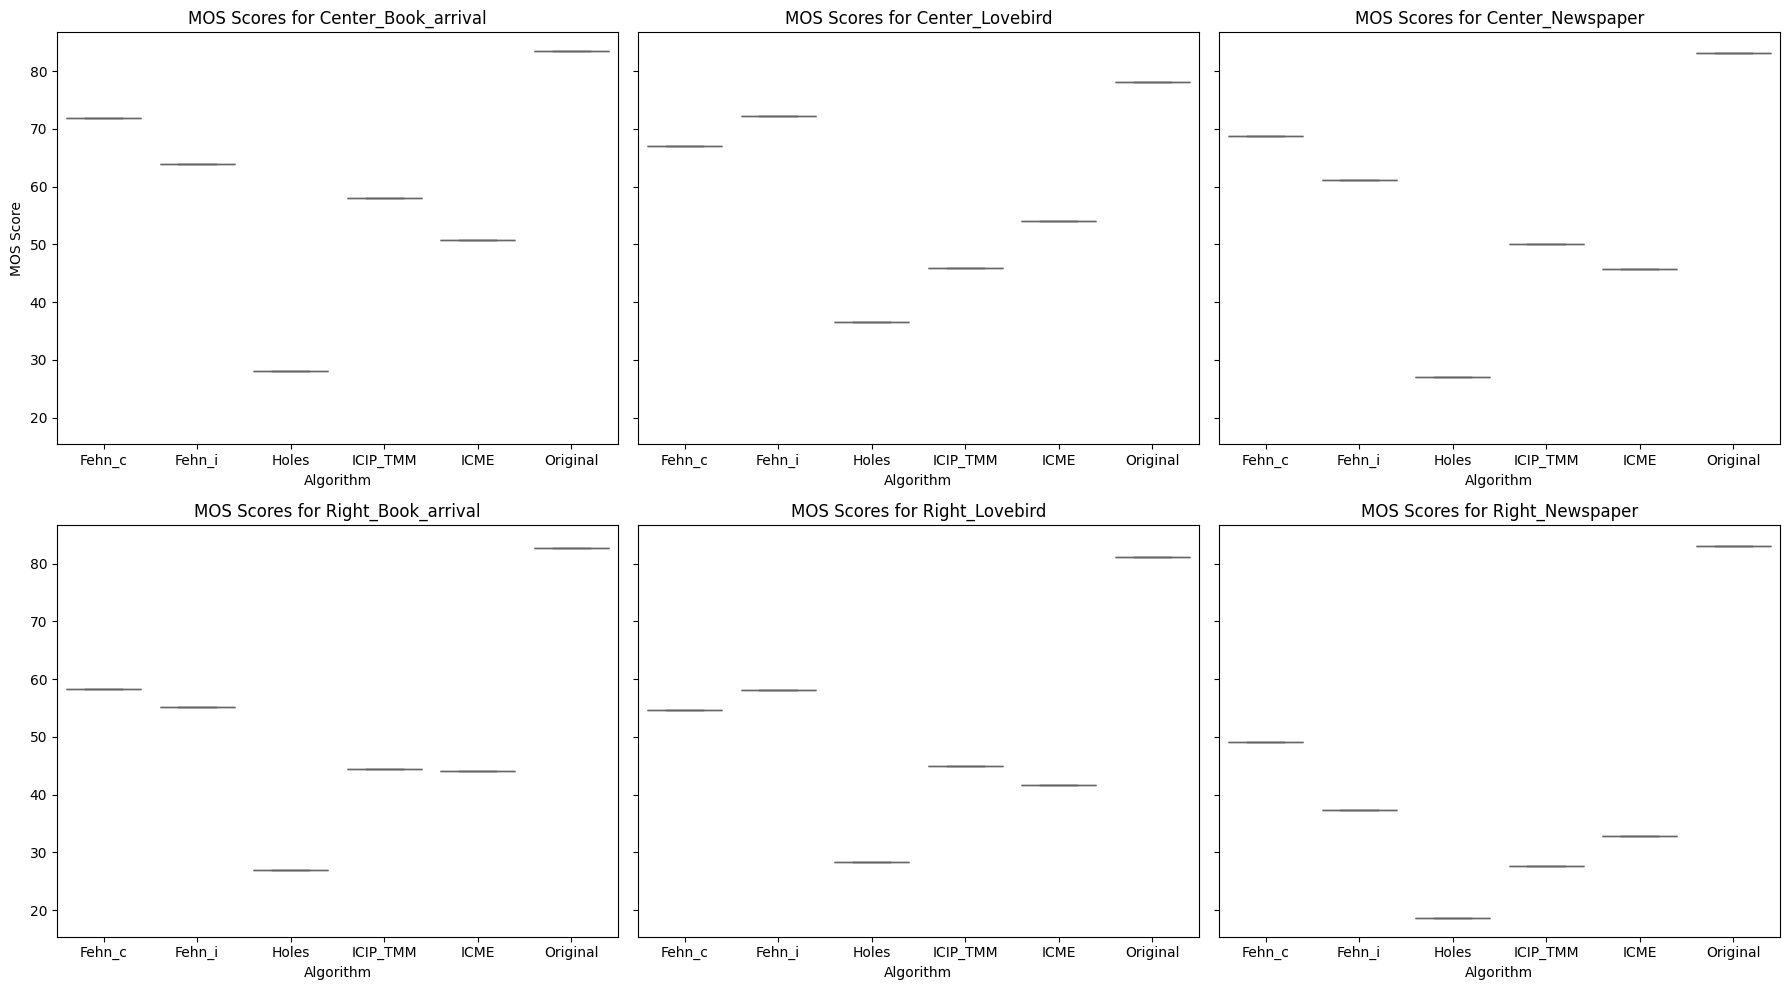

In [9]:
video_ids = df["video"].unique()
fig, axes = plt.subplots(2, 3, figsize=(18,10), sharey=True)
for i, video_id in enumerate(video_ids):
    ax = axes[i // 3, i % 3]
    subset = df[df["video"] == video_id]
    sns.boxplot(x="condition", y="MOS", data=subset, hue="condition", palette="Set3", ax=ax, legend=False)
    ax.set_title(f"MOS Scores for {video_id}")
    ax.set_xlabel("Algorithm")
    if i == 0:
        ax.set_ylabel("MOS Score")
    else:
        ax.set_ylabel("")
plt.tight_layout()
plt.show()

In [10]:
# Display MOS and CI from dataframe
print("Algorithm\t\tMean MOS ± CI")
print("-" * 50)
for algo in sorted(df['condition'].unique()):
    subset = df[df['condition'] == algo]
    mean_mos = subset['MOS'].mean()
    mean_ci = subset['CI_95'].mean()
    print(f"{algo:15s}\t{mean_mos:.3f} ± {mean_ci:.3f}  [{mean_mos-mean_ci:.3f}, {mean_mos+mean_ci:.3f}]")

Algorithm		Mean MOS ± CI
--------------------------------------------------
Fehn_c         	61.639 ± 18.408  [43.231, 80.047]
Fehn_i         	58.000 ± 16.537  [41.463, 74.537]
Holes          	27.611 ± 26.889  [0.722, 54.500]
ICIP_TMM       	45.194 ± 15.186  [30.008, 60.381]
ICME           	44.861 ± 18.138  [26.723, 62.999]
Original       	81.944 ± 32.109  [49.835, 114.054]


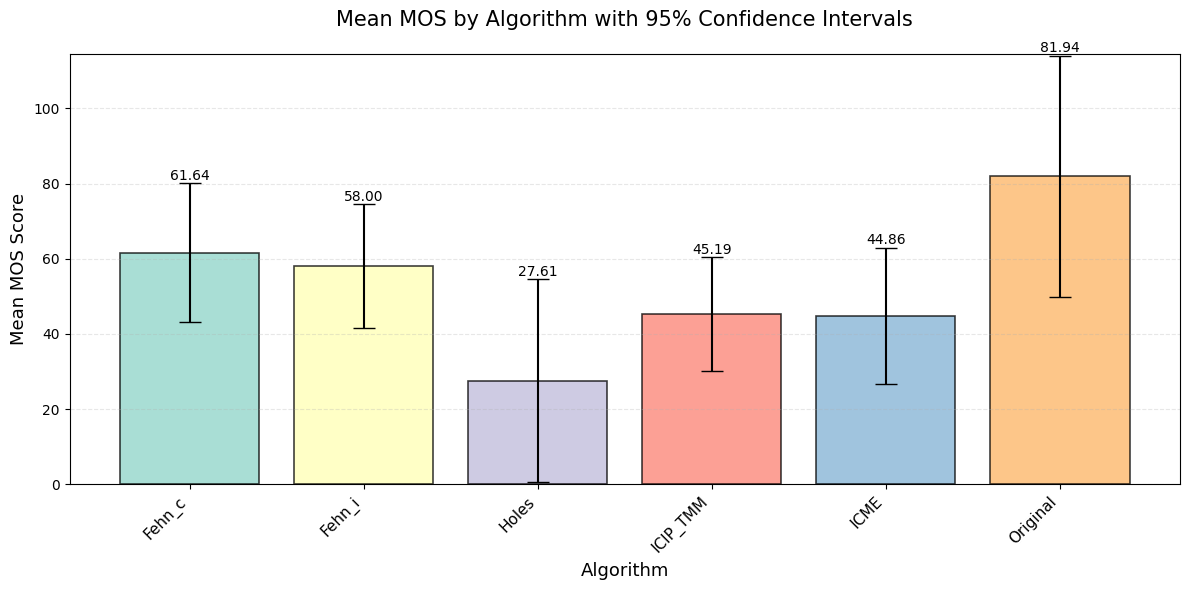

Non-overlapping CIs suggest statistically significant differences


In [11]:
# Visualization of Mean MOS with CI from dataframe
fig, ax = plt.subplots(figsize=(12, 6))

# Get means and CIs from dataframe
algos = sorted(df['condition'].unique())
means = []
cis = []

for algo in algos:
    subset = df[df['condition'] == algo]
    means.append(subset['MOS'].mean())
    cis.append(subset['CI_95'].mean())

# Create bar plot with error bars
x_pos = np.arange(len(algos))
bars = ax.bar(x_pos, means, yerr=cis, capsize=8, alpha=0.75, 
               color=sns.color_palette("Set3", len(algos)), 
               edgecolor='black', linewidth=1.2)

# Add value labels on bars
for i, (m, c) in enumerate(zip(means, cis)):
    ax.text(i, m + c + 0.05, f'{m:.2f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Algorithm', fontsize=13)
ax.set_ylabel('Mean MOS Score', fontsize=13)
ax.set_title('Mean MOS by Algorithm with 95% Confidence Intervals', fontsize=15, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(algos, rotation=45, ha='right', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(means) + max(cis) + 0.5)

plt.tight_layout()
plt.show()


print("Non-overlapping CIs suggest statistically significant differences")

#### Anova

In [12]:
# Statistical comparison: ANOVA test to check if there are significant differences between algorithms
from scipy.stats import f_oneway

# Prepare data for ANOVA
algo_groups = [group['MOS'].values for name, group in df.groupby('condition')]

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(*algo_groups)

print(f"One-Way ANOVA Results:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("\nConclusion: There are statistically significant differences between algorithms (p < 0.05)")
else:
    print("\nConclusion: No statistically significant differences between algorithms (p >= 0.05)")

One-Way ANOVA Results:
F-statistic: 30.2598
P-value: 7.304671809128637e-11

Conclusion: There are statistically significant differences between algorithms (p < 0.05)


In [13]:
#test de Dunnett
from statsmodels.stats.multicomp import pairwise_tukeyhsd
dunnett = pairwise_tukeyhsd(endog=df['MOS'], groups=df['condition'], alpha=0.05)
print(dunnett)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj   lower    upper   reject
----------------------------------------------------------
  Fehn_c   Fehn_i  -3.6389 0.9712 -18.0952  10.8174  False
  Fehn_c    Holes -34.0278    0.0 -48.4841 -19.5714   True
  Fehn_c ICIP_TMM -16.4444 0.0186 -30.9008  -1.9881   True
  Fehn_c     ICME -16.7778 0.0156 -31.2341  -2.3214   True
  Fehn_c Original  20.3056 0.0023   5.8492  34.7619   True
  Fehn_i    Holes -30.3889    0.0 -44.8452 -15.9326   True
  Fehn_i ICIP_TMM -12.8056 0.1061 -27.2619   1.6508  False
  Fehn_i     ICME -13.1389 0.0917 -27.5952   1.3174  False
  Fehn_i Original  23.9444 0.0003   9.4881  38.4008   True
   Holes ICIP_TMM  17.5833 0.0102    3.127  32.0397   True
   Holes     ICME    17.25 0.0122   2.7937  31.7063   True
   Holes Original  54.3333    0.0   39.877  68.7897   True
ICIP_TMM     ICME  -0.3333    1.0 -14.7897   14.123  False
ICIP_TMM Original    36.75    0.0  22.2937  51.2063   Tr

In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

mc = MultiComparison(df['MOS'], df['condition'])

result = mc.tukeyhsd()

filtered_results = result.summary().data[1:] 
filtered_results = [row for row in filtered_results if 'Original' in row[0] or 'Original' in row[1]]
for rows in filtered_results:
    print(rows)

['Fehn_c', 'Original', np.float64(20.3056), np.float64(0.0023), np.float64(5.8492), np.float64(34.7619), np.True_]
['Fehn_i', 'Original', np.float64(23.9444), np.float64(0.0003), np.float64(9.4881), np.float64(38.4008), np.True_]
['Holes', 'Original', np.float64(54.3333), np.float64(0.0), np.float64(39.877), np.float64(68.7897), np.True_]
['ICIP_TMM', 'Original', np.float64(36.75), np.float64(0.0), np.float64(22.2937), np.float64(51.2063), np.True_]
['ICME', 'Original', np.float64(37.0833), np.float64(0.0), np.float64(22.627), np.float64(51.5397), np.True_]


In [15]:
print("=" * 70)
print("SUMMARY: Comparison of Each Algorithm vs. Original (Control)")
print("=" * 70)
print(f"{'Algorithm':<15} {'Mean Diff':<17} {'95% CI':<12} {'p-value':<6} {'Significant?'}")
print("-" * 70)

for row in filtered_results:
    group1, group2, meandiff, pval, lower, upper, reject = row
    if 'Original' in [group1, group2]:
        other_group = group1 if group2 == 'Original' else group2
        meandiff_adj = meandiff if group1 == 'Original' else -meandiff
        lower_adj = lower if group1 == 'Original' else -lower
        upper_adj = upper if group1 == 'Original' else -upper
        
        ci_str = f"[{lower_adj:6.3f}, {upper_adj:6.3f}]"
        sig_str = "YES" if reject else "NO"
        
        print(f"{other_group:<15} {meandiff_adj:>10.4f}  {ci_str:<20} {pval:>6}  {sig_str}")

print("=" * 70)
print("\nInterpretation:")
print("- Positive Mean Diff: Algorithm performs BETTER than Original")
print("- Negative Mean Diff: Algorithm performs WORSE than Original")
print("- Significant (p < 0.05): The difference is statistically meaningful")

SUMMARY: Comparison of Each Algorithm vs. Original (Control)
Algorithm       Mean Diff         95% CI       p-value Significant?
----------------------------------------------------------------------
Fehn_c            -20.3056  [-5.849, -34.762]    0.0023  YES
Fehn_i            -23.9444  [-9.488, -38.401]    0.0003  YES
Holes             -54.3333  [-39.877, -68.790]      0.0  YES
ICIP_TMM          -36.7500  [-22.294, -51.206]      0.0  YES
ICME              -37.0833  [-22.627, -51.540]      0.0  YES

Interpretation:
- Positive Mean Diff: Algorithm performs BETTER than Original
- Negative Mean Diff: Algorithm performs WORSE than Original
- Significant (p < 0.05): The difference is statistically meaningful


## SI/TI

#### Def

In [16]:
def calculate_SI(frame):
    """
    Calculate Spatial Information (SI) for a frame.
    SI measures the spatial complexity/detail in the frame.
    
    SI = std(Sobel(frame))
    Higher SI = more spatial detail/edges
    """
    # Convert to grayscale if needed
    if len(frame.shape) == 3:
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    else:
        gray = frame
    
    # Apply Sobel operator to detect edges
    sobel_x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=3)
    sobel_y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # SI is the standard deviation of the Sobel filtered frame
    si = np.std(sobel)
    return si

def calculate_TI(frame1, frame2):
    """
    Calculate Temporal Information (TI) between two consecutive frames.
    TI measures the amount of motion/change between frames.
    
    TI = std(frame_diff)
    Higher TI = more motion/temporal change
    """
    # Convert to grayscale if needed
    if len(frame1.shape) == 3:
        gray1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    else:
        gray1 = frame1
        gray2 = frame2
    
    # Calculate frame difference
    diff = gray2.astype(np.float64) - gray1.astype(np.float64)
    
    # TI is the standard deviation of the frame difference
    ti = np.std(diff)
    return ti

def analyze_video_SI_TI(video_path, max_frames=300):
    """
    Analyze a video and return its SI and TI values.
    
    Parameters:
    - video_path: path to video file
    - max_frames: maximum number of frames to analyze (for efficiency)
    
    Returns:
    - mean_si: average SI across frames
    - max_si: maximum SI value
    - mean_ti: average TI across frame pairs
    - max_ti: maximum TI value
    """
    cap = cv.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return None, None, None, None
    
    si_values = []
    ti_values = []
    prev_frame = None
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret or frame_count >= max_frames:
            break
        
        # Calculate SI for current frame
        si = calculate_SI(frame)
        si_values.append(si)
        
        # Calculate TI if we have a previous frame
        if prev_frame is not None:
            ti = calculate_TI(prev_frame, frame)
            ti_values.append(ti)
        
        prev_frame = frame.copy()
        frame_count += 1
    
    cap.release()
    
    # Mean, max and 95th percentile
    mean_si = np.mean(si_values) if si_values else 0
    max_si = np.max(si_values) if si_values else 0
    mean_ti = np.mean(ti_values) if ti_values else 0
    max_ti = np.max(ti_values) if ti_values else 0
    p95_si = np.percentile(si_values, 95) if si_values else 0
    p95_ti = np.percentile(ti_values, 95) if ti_values else 0
    
    return mean_si, max_si, p95_si, mean_ti, max_ti, p95_ti

#### SI/TI computation

In [17]:
# Calculate SI/TI for all videos in the dataset
df['SI_mean'] = 0.0
df['SI_max'] = 0.0
df['TI_mean'] = 0.0
df['TI_max'] = 0.0
df['SI_p95'] = 0.0
df['TI_p95'] = 0.0

print("Calculating SI/TI for all videos...")
print("This may take a few minutes...\n")

for index, row in df.iterrows():
    video_name = row['Video_path']
    video_path = os.path.join(VIDEOS_PATH, video_name)
    print(f"Video path: {video_path}")  
    
    if os.path.exists(video_path):
        #print(f"Processing: {video_name[:50]}...")
        mean_si, max_si, p95_si, mean_ti, max_ti, p95_ti = analyze_video_SI_TI(video_path)
        
        df.at[index, 'SI_mean'] = mean_si
        df.at[index, 'SI_max'] = max_si
        df.at[index, 'TI_mean'] = mean_ti
        df.at[index, 'TI_max'] = max_ti
        df.at[index, 'SI_p95'] = p95_si
        df.at[index, 'TI_p95'] = p95_ti

        # If we have values == 0, we can print a warning
        if mean_si == 0:
            print(f"Warning: SI is zero for video: {video_name}")
        if mean_ti == 0:
            print(f"Warning: TI is zero for video: {video_name}")
    else:
        print(f"Video not found: {video_path}")

print("\nSI/TI calculation complete")
print("\nSample results:")
print(df[['Video_path', 'condition', 'MOS', 'SI_mean', 'TI_mean']].head(10))

Calculating SI/TI for all videos...
This may take a few minutes...

Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A1_8_to_9.avi


Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A2_8_to_9.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A7_8_to_9.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A6_8_to_9.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A5_8_to_9.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_cam_08.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Lovebird1_A1_6_to_7.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Lovebird1_A2_6_to_7.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Lovebird1_A7_6_to_7.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Lovebird1_A6_6_to_7.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Lovebird1_A5_6_to_7.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Lovebird_cam_06.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Newspaper_A1_4_to_5.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Newspaper_A2_4_to_5.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Newspaper_A7_4_to_5.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Newspaper_A6_4_to_5.avi
Vi

In [18]:
df.to_csv(output_file, index=False)
print(f"Data saved to: {output_file}")
print(f"Rows saved: {len(df)}")
print(f"Columns saved: {list(df.columns)}")

Data saved to: results/experimental_results.csv
Rows saved: 36
Columns saved: ['Video_path', 'video', 'condition', 'rating_Elliot', 'rating_Enzo', 'rating_christopher', 'rating_cla', 'rating_lou-anne', 'rating_maria', 'MOS', 'DMOS', 'CI_95', 'SI_mean', 'SI_max', 'TI_mean', 'TI_max', 'SI_p95', 'TI_p95']


#### Plots

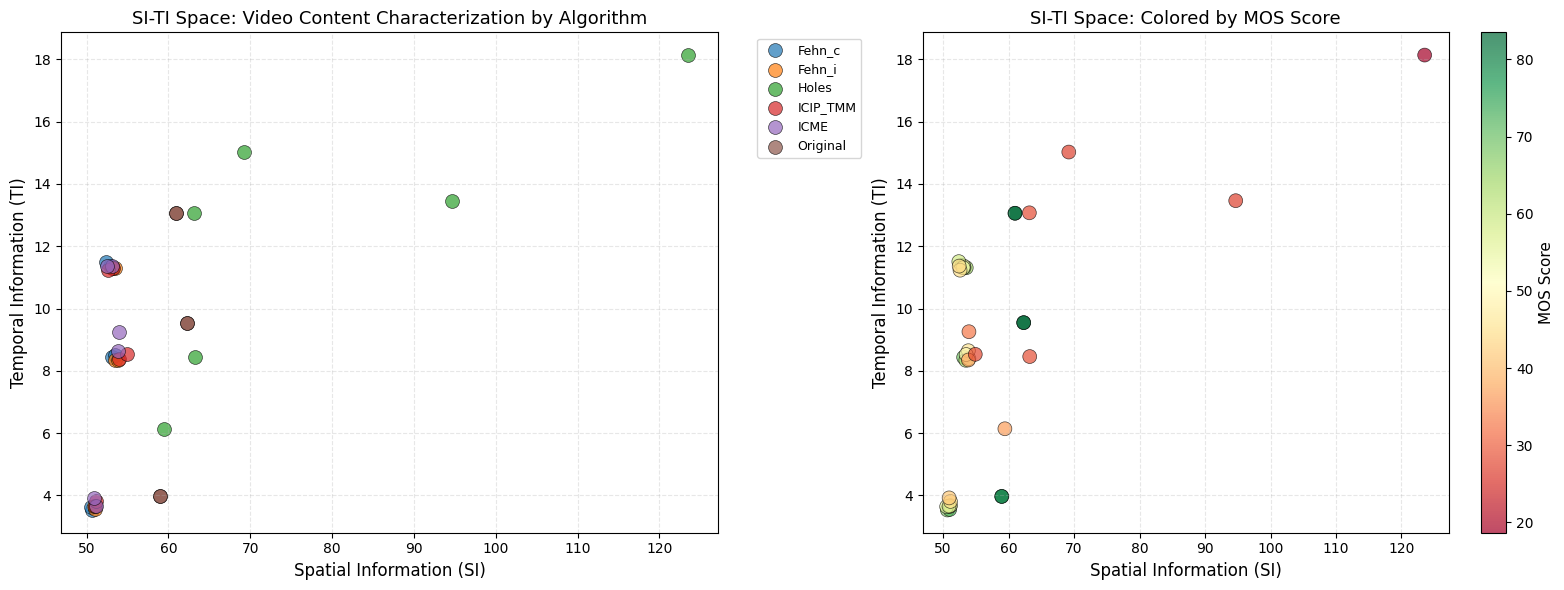


Interpretation:
- Each point represents one video
- High SI = spatially complex content (detailed scenes)
- High TI = high motion content
- Colors in right plot show if high SI/TI correlates with lower/higher MOS


In [20]:
# Visualization 1: SI/TI scatter plot colored by algorithm
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: SI/TI space
for algo in sorted(df['condition'].unique()):
    subset = df[df['condition'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')

# Plot 2: SI/TI colored by MOS
scatter = axes[1].scatter(df['SI_mean'], df['TI_mean'], 
                         c=df['MOS'], cmap='RdYlGn', 
                         s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Colored by MOS Score', fontsize=13)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('MOS Score', fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Each point represents one video")
print("- High SI = spatially complex content (detailed scenes)")
print("- High TI = high motion content")
print("- Colors in right plot show if high SI/TI correlates with lower/higher MOS")

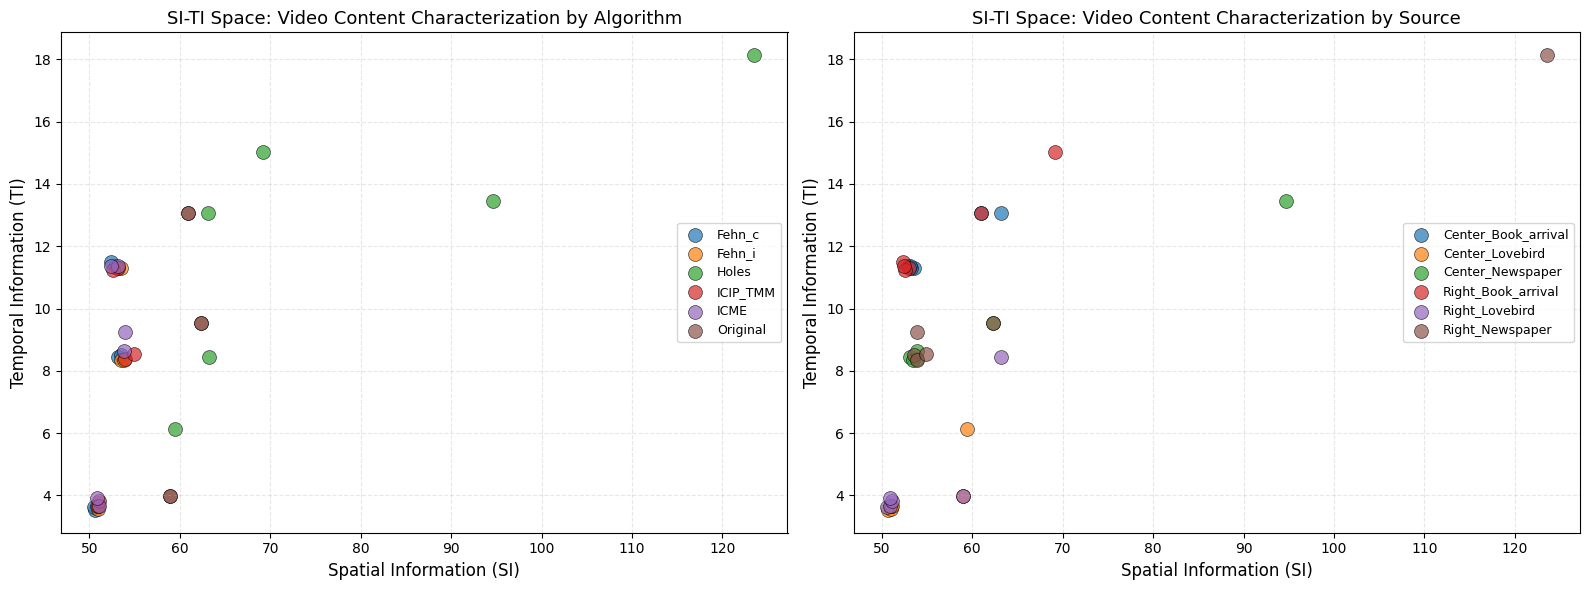

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for algo in sorted(df['condition'].unique()):
    subset = df[df['condition'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(loc='right', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')

for source in sorted(df['video'].unique()):
    subset = df[df['video'] == source]
    scatter = axes[1].scatter(subset['SI_mean'], subset['TI_mean'],  label = source, 
                             alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Video Content Characterization by Source', fontsize=13)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].legend(loc='right', fontsize=9)

plt.tight_layout()
plt.show()

## Objective QA : SSIM, VIFP,.......

##### Metrics

In [24]:
import torch
import piq
import lpips
from skimage.metrics import structural_similarity as ssim

loss_fn = lpips.LPIPS(net='vgg')

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/raclax/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/raclax/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/raclax/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:24<00:00, 22.7MB/s] 


Loading model from: /home/raclax/miniconda3/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth


##### Computation

In [ ]:
df['SSIM'] = np.nan
df['LPIPS'] = np.nan
df['VIFP'] = np.nan
df['MS_SSIM'] = np.nan

for index, row in df.iterrows():
    video_name = row['Video_path']
    video_path = os.path.join(VIDEOS_PATH, video_name)

    if row['condition'] == 'Original':
        df.at[index, 'SSIM'] = np.nan
        df.at[index, 'LPIPS'] = np.nan
        df.at[index, 'VIFP'] = np.nan
        df.at[index, 'MS_SSIM'] = np.nan
        continue

    # Récupérer le path de la vidéo de référence (déjà trouvé dans le prétraitement) TODO
    ref_video_name = row['ref_video_path']
    
    if pd.isna(ref_video_name):
        print(f"No ref for : {video_name}")
        continue
    
    video_ref_path = os.path.join(VIDEOS_PATH, ref_video_name)

    print(f"Video: {video_name}, ref: {ref_video_name}")

    if os.path.exists(video_path) and os.path.exists(video_ref_path):
        ssim_score = ssim(video_ref_path, video_path)
        lpips_score = loss_fn.forward(video_ref_path, video_path)
        vifp_score = piq.vif_p(video_ref_path, video_path)
        ms_ssim_score = piq.multi_scale_ssim(video_ref_path, video_path)

        df.at[index, 'SSIM'] = ssim_score
        df.at[index, 'LPIPS'] = lpips_score
        df.at[index, 'VIFP'] = vifp_score
        df.at[index, 'MS_SSIM'] = ms_ssim_score
    else:
        if not os.path.exists(video_path):
            print(f"  Vidéo introuvable: {video_path}")

print("Objective metrics computed (SSIM + LPIPS + VIFP + MS_SSIM).")
df[['video', 'condition', 'MOS', 'video_path', 'SSIM', 'LPIPS', 'VIFP', 'MS_SSIM']].head(10)

KeyError: 'ref_video_path'

In [ ]:
df.to_csv(output_file, index=False)
print(f"Data saved to: {output_file}")
print(f"Rows saved: {len(df)}")
print(f"Columns saved: {list(df.columns)}")

#### Plots

In [ ]:
# Filter out NaN values for analysis (only non-Original videos have objective metrics)
df_metrics = df[df['condition'] != 'Original'].copy()
df_metrics = df_metrics.dropna(subset=['SSIM', 'LPIPS', 'VIFP', 'MS_SSIM', 'MOS'])

print(f"\n" + "="*70)
print("METRICS STATISTICS")
print("="*70)
print(df_metrics[['SSIM', 'LPIPS', 'VIFP', 'MS_SSIM', 'MOS']].describe())

## x